C:\Users\Dell\AppData\Local\Temp\ipykernel_14540\4157438463.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


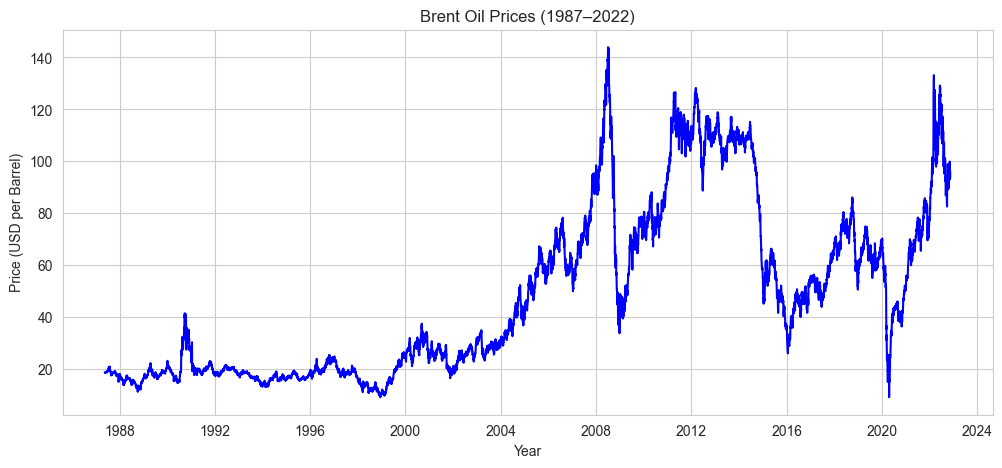

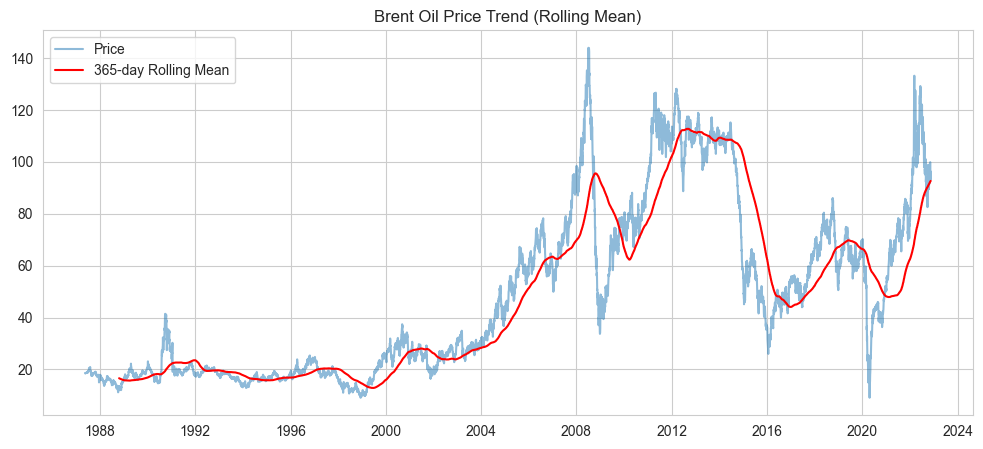

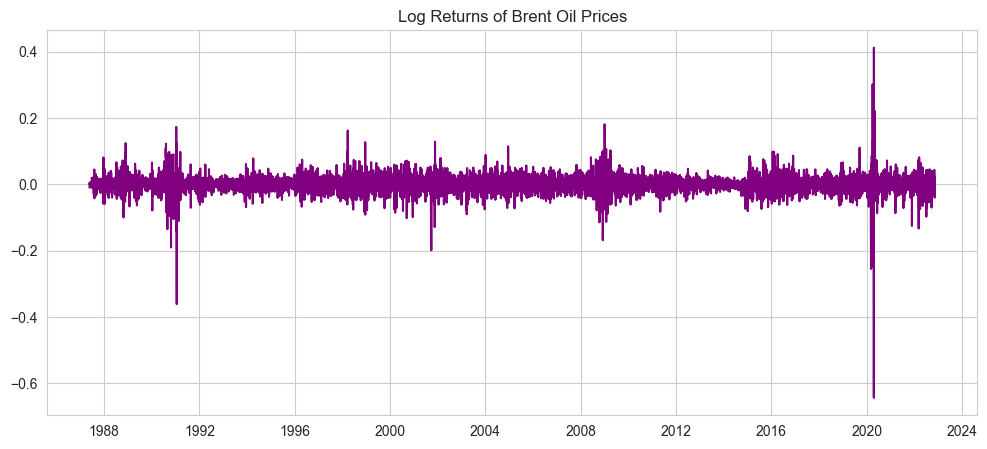

ADF on Price: {'ADF Statistic': np.float64(-1.9938560113924675), 'p-value': np.float64(0.28927350489340287)}
ADF on Log Returns: {'ADF Statistic': np.float64(-16.42711349448591), 'p-value': np.float64(2.4985801611427818e-29)}
  Event_Date                          Event_Description               Category
0 2003-03-20                    US-led invasion of Iraq  Geopolitical Conflict
1 2008-09-15  Global Financial Crisis (Lehman Collapse)         Economic Shock
2 2010-12-17                         Arab Spring begins  Political Instability
3 2014-11-27           OPEC maintains production levels            OPEC Policy
4 2016-01-16                      Iran sanctions lifted              Sanctions
- Brent oil prices show long-term non-stationary behavior.
- Log returns display volatility clustering, especially during crises (2008, 2020, 2022).
- Rolling mean highlights major regime shifts and long-term trends.
- ADF test confirms log returns are stationary, suitable for change point modeling.

In [2]:
# -----------------------------
# Task 1: Brent Oil Price EDA
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# -----------------------------
# 1️⃣ Functions
# -----------------------------
def load_brent_data(path: Path) -> pd.DataFrame:
    """
    Load Brent oil price data, parse dates, sort and set index.
    """
    if not path.exists():
        raise FileNotFoundError(f"CSV not found: {path}")
    
    df = pd.read_csv(path)
    if 'Date' not in df.columns or 'Price' not in df.columns:
        raise ValueError("CSV must contain 'Date' and 'Price' columns.")
    
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date', 'Price'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    return df

def plot_price(df: pd.DataFrame, save_path: Path = None):
    """Plot price series with optional save."""
    plt.plot(df.index, df['Price'], color='blue')
    plt.title("Brent Oil Prices (1987–2022)")
    plt.xlabel("Year")
    plt.ylabel("Price (USD per Barrel)")
    if save_path:
        plt.savefig(save_path)
    plt.show()

def add_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    """Compute log returns."""
    df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))
    return df

def adf_test(series: pd.Series) -> dict:
    """Perform ADF test and return results."""
    if len(series.dropna()) < 10:
        raise ValueError("Time series too short for ADF test.")
    result = adfuller(series.dropna())
    return {"ADF Statistic": result[0], "p-value": result[1]}

def create_event_dataset(path: Path):
    """Create structured events CSV."""
    events = [
        ("2003-03-20", "US-led invasion of Iraq", "Geopolitical Conflict"),
        ("2008-09-15", "Global Financial Crisis (Lehman Collapse)", "Economic Shock"),
        ("2010-12-17", "Arab Spring begins", "Political Instability"),
        ("2014-11-27", "OPEC maintains production levels", "OPEC Policy"),
        ("2016-01-16", "Iran sanctions lifted", "Sanctions"),
        ("2016-11-30", "OPEC production cut agreement", "OPEC Policy"),
        ("2018-05-08", "US exits Iran nuclear deal", "Sanctions"),
        ("2020-03-11", "COVID-19 declared a pandemic", "Global Crisis"),
        ("2020-04-12", "OPEC+ historic production cuts", "OPEC Policy"),
        ("2021-10-01", "Global energy supply crunch", "Economic Shock"),
        ("2022-02-24", "Russia invades Ukraine", "Geopolitical Conflict"),
        ("2022-03-08", "US bans Russian oil imports", "Sanctions"),
        ("2022-06-02", "OPEC+ limited output increase", "OPEC Policy")
    ]
    df_events = pd.DataFrame(events, columns=["Event_Date", "Event_Description", "Category"])
    df_events['Event_Date'] = pd.to_datetime(df_events['Event_Date'])
    df_events.to_csv(path, index=False)
    return df_events

# -----------------------------
# 2️⃣ Paths
# -----------------------------
BASE_DIR = Path().resolve()  # Notebook current working directory
RAW_PATH = BASE_DIR / "../data/raw/BrentOilPrices.csv"
EVENTS_PATH = BASE_DIR / "../data/processed/events.csv"
IMAGES_PATH = BASE_DIR / "../images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# -----------------------------
# 3️⃣ Main Workflow
# -----------------------------
try:
    # Load data
    df = load_brent_data(RAW_PATH)
    
    # Plot prices
    plot_price(df, IMAGES_PATH / "brent_price.png")
    
    # Trend & Rolling Mean
    df['RollingMean_365'] = df['Price'].rolling(365).mean()
    plt.plot(df['Price'], alpha=0.5, label='Price')
    plt.plot(df['RollingMean_365'], color='red', label='365-day Rolling Mean')
    plt.title("Brent Oil Price Trend (Rolling Mean)")
    plt.legend()
    plt.show()
    
    # Log returns
    df = add_log_returns(df)
    plt.plot(df['Log_Returns'], color='purple')
    plt.title("Log Returns of Brent Oil Prices")
    plt.show()
    
    # Stationarity
    adf_price_result = adf_test(df['Price'])
    adf_returns_result = adf_test(df['Log_Returns'])
    print("ADF on Price:", adf_price_result)
    print("ADF on Log Returns:", adf_returns_result)
    
    # Events
    events_df = create_event_dataset(EVENTS_PATH)
    print(events_df.head())
    
except Exception as e:
    print(f"Error occurred: {e}")

# -----------------------------
# 4️⃣ Observations
# -----------------------------
observations = [
    "Brent oil prices show long-term non-stationary behavior.",
    "Log returns display volatility clustering, especially during crises (2008, 2020, 2022).",
    "Rolling mean highlights major regime shifts and long-term trends.",
    "ADF test confirms log returns are stationary, suitable for change point modeling.",
    "Structured event dataset enables linking price shifts to geopolitical/economic events."
]

for obs in observations:
    print("-", obs)
